# [KO] Fall Detection with BERT-base-multilingual-cased (Using GPU)

In [2]:
GPU_NUM = 1

In [3]:
DATA_TYPE = "anonym"
LANGUAGE = "ko"

In [4]:
# DATA_TYPE = "translation"
# LANGUAGE = "en"

In [5]:
HUGGINGFACE_MODEL_PATH = "bert-base-multilingual-cased"

In [6]:
BATCH_SIZE = 32

In [7]:
EPOCHS = 6

In [8]:
import os

MODEL_NAME = f"{HUGGINGFACE_MODEL_PATH.replace('/', '-')}-{LANGUAGE}-{DATA_TYPE}-{BATCH_SIZE}"
MODEL_DIR = f"./model/{MODEL_NAME}/{MODEL_NAME}"
MODEL_PATH = os.path.abspath(MODEL_DIR)

print(MODEL_PATH)

C:\Users\ADMIN\Projects\Fall_Detection\model\bert-base-multilingual-cased-ko-anonym-32\bert-base-multilingual-cased-ko-anonym-32


In [9]:
# pip install transformers

In [10]:
import transformers
transformers.__version__

'4.22.2'

In [11]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split

In [12]:
dataset = pd.read_csv("data/dataset_10103_34480.csv")

In [13]:
RANDOM_STATE = 42

In [14]:
X = dataset
y = dataset['label']

# Split dataset
# Train : Test = 8 : 2
train_data, test_data, y_train, y_test=train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        shuffle=True,
                                                        stratify=y,
                                                        random_state=RANDOM_STATE)

train_data = train_data.reset_index()
# valid_data = valid_data.reset_index()
test_data  = test_data.reset_index()

y_train = y_train.reset_index()['label']
# y_valid = y_valid.reset_index()['label']
y_test  = y_test.reset_index()['label']

print(f'--- Rate of Falls in Train Datasets (N = {len(y_train)}) ---')
print(f'Non-Fall Data (label : 0) = {y_train.value_counts()[0]} ({round(y_train.value_counts()[0]/len(y_train) * 100,3)})%')
print(f'    Fall Data (label : 1) = {y_train.value_counts()[1]} ({round(y_train.value_counts()[1]/len(y_train) * 100,3)})%')
print()
# print(f'--- Rate of Falls in Validation Datasets (N = {len(y_valid)}) ---')
# print(f'Non-Fall Data (label : 0) = {y_valid.value_counts()[0]} ({round(y_valid.value_counts()[0]/len(y_valid) * 100,3)})%')
# print(f'    Fall Data (label : 1) = {y_valid.value_counts()[1]} ({round(y_valid.value_counts()[1]/len(y_valid) * 100,3)})%')
print()
print(f'--- Rate of Falls in Test Datasets (N = {len(y_test)}) ---')
print(f'Non-Fall Data (label : 0) = {y_test.value_counts()[0]} ({round(y_test.value_counts()[0]/len(y_test) * 100,3)})%')
print(f'    Fall Data (label : 1) = {y_test.value_counts()[1]} ({round(y_test.value_counts()[1]/len(y_test) * 100,3)})%')

--- Rate of Falls in Train Datasets (N = 27584) ---
Non-Fall Data (label : 0) = 19502 (70.7)%
    Fall Data (label : 1) = 8082 (29.3)%


--- Rate of Falls in Test Datasets (N = 6896) ---
Non-Fall Data (label : 0) = 4875 (70.693)%
    Fall Data (label : 1) = 2021 (29.307)%


In [15]:
print('훈련용 데이터 개수 :', len(train_data)) # 훈련용 데이터 개수 출력

훈련용 데이터 개수 : 27584


In [16]:
print('테스트용 데이터 개수 :',len(test_data)) # 테스트용 데이터 개수 출력

테스트용 데이터 개수 : 6896


In [17]:
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
train_data = train_data.reset_index(drop=True)
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False
False


In [18]:
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
test_data = test_data.reset_index(drop=True)
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

False
False


In [19]:
print(len(train_data))

27584


In [20]:
print(len(test_data))

6896


서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 데이터와 전체 데이터의 길이 분포를 알아보겠습니다.

데이터의 최대 길이 : 1915
데이터의 평균 길이 : 142.81608903712296


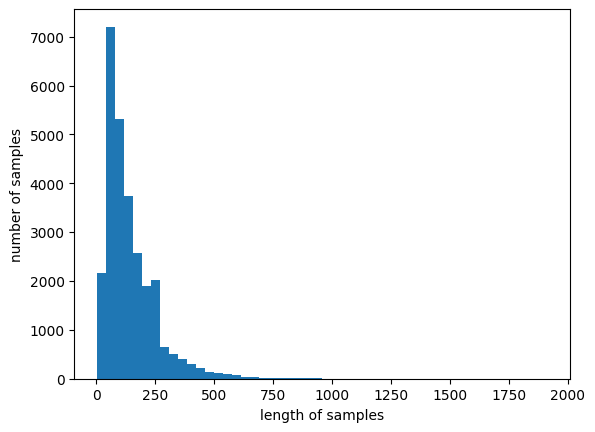

In [21]:
print('데이터의 최대 길이 :',max(len(data) for data in train_data[DATA_TYPE]))
print('데이터의 평균 길이 :',sum(map(len, train_data[DATA_TYPE]))/len(train_data))
plt.hist([len(data) for data in train_data[DATA_TYPE]], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

데이터의 최대 길이는 1915, 평균 길이는 약 143입니다. 그래프로 봤을 때, 전체적으로는 700이하의 길이를 가지는 것으로 보입니다.

In [22]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

만약 650으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인해봅시다.

In [23]:
max_seq_len = 650
below_threshold_len(max_seq_len, train_data[DATA_TYPE])

전체 샘플 중 길이가 650 이하인 샘플의 비율: 99.57221577726219


훈련용 데이터의 99.52%가 650이하의 길이를 가집니다. 훈련용 데이터를 길이 650으로 패딩하겠습니다.

## Load `tokenizer` from Huggingface

In [24]:
tokenizer = BertTokenizer.from_pretrained(HUGGINGFACE_MODEL_PATH, from_pt=True)

## Encode datasets

In [25]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    
    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, truncation=True, max_length=max_seq_len, pad_to_max_length=True)
       
        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스.
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
        
        # token_type_id는 세그먼트 임베딩을 위한 것으로 이번 예제는 문장이 1개이므로 전부 0으로 통일.
        token_type_id = [0] * max_seq_len

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [26]:
train_X, train_y = convert_examples_to_features(train_data[DATA_TYPE], train_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|                                                                                       | 0/27584 [00:00<?, ?it/s]C:\Users\ADMIN\anaconda3\envs\nlp\lib\site-packages\transformers\tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████| 27584/27584 [00:17<00:00, 1600.68it/s]


In [27]:
test_X, test_y = convert_examples_to_features(test_data[DATA_TYPE], test_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|███████████████████████████████████████████████████████████████████████████| 6896/6896 [00:04<00:00, 1594.39it/s]


In [28]:
# 최대 길이: 650
input_id = train_X[0][0]
attention_mask = train_X[1][0]
token_type_id = train_X[2][0]
label = train_y[0]

# print('단어에 대한 정수 인코딩 :',input_id)
# print('어텐션 마스크 :',attention_mask)
# print('세그먼트 인코딩 :',token_type_id)
# print('각 인코딩의 길이 :', len(input_id))
# print('정수 인코딩 복원 :',tokenizer.decode(input_id))
# print('레이블 :',label)

## Prepare pre-trained model from Huggingface

In [29]:
model = TFBertModel.from_pretrained(HUGGINGFACE_MODEL_PATH, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [30]:
input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
attention_masks_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
token_type_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)

outputs = model([input_ids_layer, attention_masks_layer, token_type_ids_layer])

In [39]:
class TFBertForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name):
        super(TFBertForSequenceClassification, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
        self.classifier = tf.keras.layers.Dense(1,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='sigmoid',
                                                name='classifier')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_token = outputs[1]
        prediction = self.classifier(cls_token)

        return prediction

## Compile the model

In [40]:
tf.random.set_seed(RANDOM_STATE)

In [41]:
with tf.device(f"/GPU:{GPU_NUM}"):
    model = TFBertForSequenceClassification(HUGGINGFACE_MODEL_PATH)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    
    model.compile(optimizer=optimizer, loss=loss, metrics=[
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall'),
                                tf.keras.metrics.FalsePositives(name='false_positives'),
                                tf.keras.metrics.FalseNegatives(name='false_negatives'),
                                'accuracy'],
                 )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [42]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# earlyStopping = EarlyStopping(monitor='val_recall', patience=7, verbose=1, mode='auto')
mcp_save = ModelCheckpoint(MODEL_PATH, save_best_only=True, save_weights_only=True, monitor='val_recall', mode='max')
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')

# custom_callback = [earlyStopping, mcp_save, reduce_lr_loss]
custom_callback = [mcp_save]

## Train the model

In [43]:
model.fit(train_X, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, 
          callbacks=custom_callback, 
          validation_split=0.25)

Epoch 1/20
647/647 [==============================] - 933s 1s/step - loss: 0.0668 - precision: 0.9580 - recall: 0.9655 - false_positives: 258.0000 - false_negatives: 210.0000 - accuracy: 0.9774 - val_loss: 0.0633 - val_precision: 0.9377 - val_recall: 0.9965 - val_false_positives: 132.0000 - val_false_negatives: 7.0000 - val_accuracy: 0.9798 - lr: 5.0000e-05
Epoch 2/20
647/647 [==============================] - 917s 1s/step - loss: 0.0427 - precision: 0.9744 - recall: 0.9811 - false_positives: 157.0000 - false_negatives: 115.0000 - accuracy: 0.9869 - val_loss: 0.0777 - val_precision: 0.9324 - val_recall: 0.9970 - val_false_positives: 144.0000 - val_false_negatives: 6.0000 - val_accuracy: 0.9782 - lr: 5.0000e-05
Epoch 3/20
647/647 [==============================] - 1096s 2s/step - loss: 0.0338 - precision: 0.9788 - recall: 0.9867 - false_positives: 130.0000 - false_negatives: 81.0000 - accuracy: 0.9898 - val_loss: 0.0428 - val_precision: 0.9676 - val_recall: 0.9890 - val_false_positives:

In [ ]:
results = model.evaluate(test_X, test_y, batch_size=128)
print("test results: ", results)

## Load the best model and Evaluate performances

### Load the best model

In [ ]:
# class TFBertForSequenceClassification(tf.keras.Model):
#     def __init__(self, model_name):
#         super(TFBertForSequenceClassification, self).__init__()
#         self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
#         self.classifier = tf.keras.layers.Dense(1,
#                                                 kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
#                                                 activation='sigmoid',
#                                                 name='classifier')

#     def call(self, inputs):
#         input_ids, attention_mask, token_type_ids = inputs
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
#         cls_token = outputs[1]
#         prediction = self.classifier(cls_token)

#         return prediction

In [33]:
with tf.device(f"/GPU:{GPU_NUM}"):
    best_model = TFBertForSequenceClassification(HUGGINGFACE_MODEL_PATH)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    
    best_model.compile(optimizer=optimizer, loss=loss, metrics=[
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall'),
                                tf.keras.metrics.FalsePositives(name='false_positives'),
                                tf.keras.metrics.FalseNegatives(name='false_negatives'),
                                'accuracy'],
                 )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [34]:
best_model.load_weights(MODEL_PATH)

## Evaluate performances of the best model

In [36]:
results = best_model.evaluate(test_X, test_y, batch_size=128)
print("test results: ", results)

54/54 [==============================] - 82s 2s/step - loss: 0.0385 - precision: 0.9636 - recall: 0.9955 - false_positives: 76.0000 - false_negatives: 9.0000 - accuracy: 0.9877
test results:  [0.03853351250290871, 0.9636015295982361, 0.9955467581748962, 76.0, 9.0, 0.9876739978790283]
